# Query By Committee

In this notebook we will combine the classifiers studied in the last notebook to implement the query by committee query strategy.
***

In [1]:
## Imports ##

# numpy
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier, MixtureModelClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee
from skactiveml.utils import MISSING_LABEL

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

We will compare the query by committee strategy against the standard uncertainty sampling.

In [2]:
def get_accuracy_uncertainty(classifier, weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = UncertaintySampling(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(classifier, classes=np.unique(yf))

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clf)
            y[i] = yf[i]
            clf.fit(Xf,y)
            predicted_y = clf.predict(Xt)
            out.append(balanced_accuracy(yt, predicted_y))
        data.append(out)

    return np.mean(np.array(data), axis=0)

def get_accuracy_committee(weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = QueryByCommittee(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clfs = [SklearnClassifier(LogisticRegression(), classes=np.unique(yf)),
                SklearnClassifier(SGDClassifier(loss='modified_huber'), classes=np.unique(yf)),
                SklearnClassifier(MLPClassifier(), classes=np.unique(yf)),
                ParzenWindowClassifier(classes=np.unique(yf)),
                MixtureModelClassifier(classes=np.unique(yf))
               ]
                
        
        for clf in clfs:
            clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clfs)
            y[i] = yf[i]
            accumulated_acc = 0
            for clf in clfs:
                clf.fit(Xf,y)
                predicted_y = clf.predict(Xt)
                accumulated_acc += balanced_accuracy(yt, predicted_y)
            out.append(accumulated_acc/len(clfs)) # mean of accuracies
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [3]:
acc_uncertainty_logistic = get_accuracy_uncertainty(LogisticRegression(), weights=[0.8, 0.2])

In [4]:
acc_uncertainty_sgd = get_accuracy_uncertainty(SGDClassifier(loss='modified_huber'), weights=[0.8, 0.2])

In [5]:
acc_uncertainty_mlp = get_accuracy_uncertainty(MLPClassifier(), weights=[0.8, 0.2])

In [6]:
acc_committee = get_accuracy_committee(weights=[0.8, 0.2])

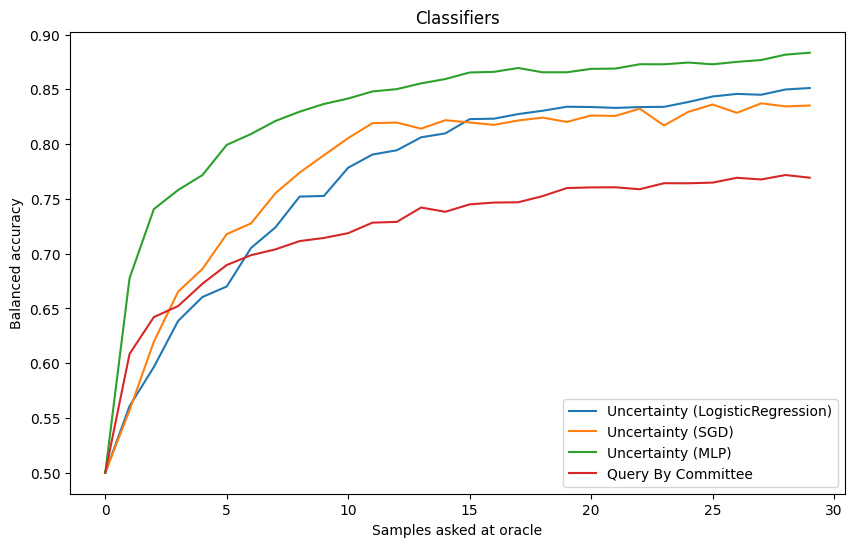

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Classifiers', [[acc_uncertainty_logistic, "Uncertainty (LogisticRegression)"], [acc_uncertainty_sgd, "Uncertainty (SGD)"], [acc_uncertainty_mlp, "Uncertainty (MLP)"], [acc_committee, "Query By Committee"]], axs)

fig.show()

We can see the query by committee strategy does perform really well but is slowed down by the bad MixtureModelClassifier.

We will rerun the above experiment with only the relativly good classifiers. We also average the results for the uncertainty sampling.

In [8]:
def get_accuracy_committee(weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = QueryByCommittee(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clfs = [SklearnClassifier(LogisticRegression(), classes=np.unique(yf)),
                SklearnClassifier(SGDClassifier(loss='modified_huber'), classes=np.unique(yf)),
                SklearnClassifier(MLPClassifier(), classes=np.unique(yf)),
               ]
                
        
        for clf in clfs:
            clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clfs)
            y[i] = yf[i]
            accumulated_acc = 0
            for clf in clfs:
                clf.fit(Xf,y)
                predicted_y = clf.predict(Xt)
                accumulated_acc += balanced_accuracy(yt, predicted_y)
            out.append(accumulated_acc/len(clfs)) # mean of accuracies
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [9]:
acc_uncertainty = (acc_uncertainty_logistic + acc_uncertainty_sgd + acc_uncertainty_mlp) / 3

In [10]:
acc_committee = get_accuracy_committee(weights=[0.8, 0.2])

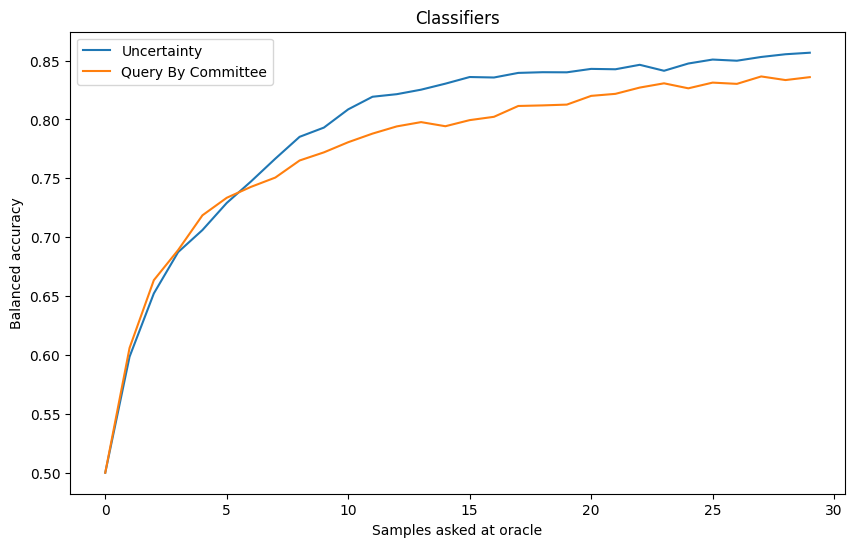

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Classifiers', [[acc_uncertainty, "Uncertainty"], [acc_committee, "Query By Committee"]], axs)

fig.show()